<a href="https://colab.research.google.com/github/SpandanaKalakonda/LLMS/blob/main/llm_with_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!pip install langchain langgraph cassio langchain_community langchain_groq tiktoken langchainhub langchain_huggingface -q

In [81]:
!pip install wikipedia -q

In [46]:
from google.colab import userdata
ASTRA_DB_TOKEN = userdata.get('ASTRA_DB_TOKEN')
ASTRA_DB_ID = userdata.get('ASTRA_DB_ID')

In [47]:
#Connecting to ASTRADB
import cassio
cassio.init(token=ASTRA_DB_TOKEN,database_id=ASTRA_DB_ID )

In [48]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
# Docs to index
urls = [
    "https://www.geeksforgeeks.org/machine-learning-algorithms/"
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [doc for sublist in docs for doc in sublist]
#Spilt
text_spiltter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=200, chunk_overlap=0)
docs_spilt = text_spiltter.split_documents(doc_list)

In [50]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [51]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store = Cassandra(
    embedding=embeddings,
    table_name="ml_algorithms_info",
    session=None,
    keyspace=None
)

In [52]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_spilt)
print("Inserted %i records." % len(docs_spilt))
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 67 records.


In [67]:
retriever = astra_vector_store.as_retriever()
retriever.invoke("What is Linear Regression", ConsistencyLevel='LOCAL_ONE')

[Document(metadata={'description': 'Explore key ML algorithms: Linear & Logistic Regression, Decision Trees, SVM. Dive into types of Machine Learning Algorithms in this guide.', 'language': 'en-US', 'source': 'https://www.geeksforgeeks.org/machine-learning-algorithms/', 'title': 'Machine Learning Algorithms'}, page_content='B. Regression\n1. Linear Regression\n\nDescription: Linear regression models the relationship between dependent and independent variables using a linear approach.\nKey Points:\n\nSimple and easy to implement.\nAssumes a linear relationship between the variables.\nSensitive to outliers.\n\n\nApplications: House price prediction, sales forecasting, risk management.\n\n2. Ridge Regression\n\nDescription: Ridge regression adds L2 regularization to linear regression to handle multicollinearity and prevent overfitting.\nKey Points:\n\nShrinks coefficients to reduce overfitting.\nHandles multicollinearity well.\nRequires tuning of the regularization parameter.\n\n\nApplica

In [54]:
## langraph application
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [68]:
# Data Model
class RouteQuery(BaseModel):
  datasource: Literal['vectorstore', 'wiki_search'] = Field(
      ...,
      description="When a user gives a question choose to route it to vectorstore OR Wikipedia"
  )

In [69]:
from langchain_groq import ChatGroq
groq_api_key = userdata.get('GROQ_API_KEY')

In [70]:
#Large Larguage Model
llm = ChatGroq(groq_api_key=groq_api_key,
               model_name='Gemma2-9b-It')

In [71]:
structured_llm_router = llm.with_structured_output(RouteQuery)

In [72]:
#Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""

route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}"),
])


In [73]:
question_router = route_prompt | structured_llm_router

In [74]:
print(question_router.invoke({"question": "Machine learning"}))

datasource='vectorstore'


In [76]:
print(question_router.invoke({"question": "Logistic Regression"}))

datasource='vectorstore'


In [78]:
print(question_router.invoke({"question": "Linear algebra"}))

datasource='wiki_search'


In [85]:
### Working With Tools
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

## Wikipedia Tools

wiki_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [101]:
#AI Agents applicatin using langgraph

from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    '''
    Represents the state of the graph.

    Attributes:
        question: question
        generation: LLM generated response
        documents: List of documents
    '''
    question: str
    generation: str
    documents: List[str]

In [172]:
from langchain.schema import Document

def retrieve(state):
  """
  Retrieve documents from the vectorstore based on the question

  Args:
    state(dict): the current Graph State

  Returns:
    State(dict): New key added to state, documents that contains retrieved documents
  """
  print("---Retreive---")
  question=state['question']

  #Retrival
  documents=retriever.invoke(question)

  return {"documents":documents,"question":questions}

In [116]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [117]:
#Edges
def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [118]:
from langgraph.graph import START,END,StateGraph

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # wikipedia search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

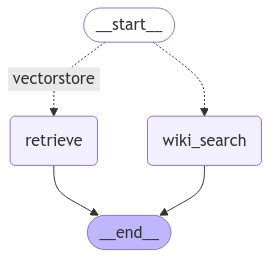

In [119]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [170]:
from pprint import pprint

# Run
inputs = {
    "question": "logistic regression"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
# Final generation
pprint(value['documents'].dict()['page_content'])

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
logistic regression
"Node 'wiki_search':"
('Page: Logistic regression\n'
 'Summary: In statistics, the logistic model (or logit model) is a statistical '
 'model that models the log-odds of an event as a linear combination of one or '
 'more independent var')


In [162]:
['from pprint import pprint

# Run
inputs = {
    "question": "Machine Learning"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")

print("Response:")
# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---


---ROUTE QUESTION TO RAG---
---Retreive---
"Node 'retrieve':"
Response:
('Explore key ML algorithms: Linear & Logistic Regression, Decision Trees, '
 'SVM. Dive into types of Machine Learning Algorithms in this guide.')
